# Programming Assignment: Text similarity and Function approximation

## Instructions

The following task consists of two parts. An answer to each of them will contain a set of numbers, which you will need to enter into the corresponding field, using the space as a separator.

**Exercise 1: Sentence comparison**

There is a set of sentences, which were copied from Wikipedia. Each of them contains a "cat theme" in it, which meaning can correspond to:

* cats (animals)
* UNIX utility cat to output the contents of files
* OS X operating system versions named after the Felidae

Your task is to find the two sentences that are closest in meaning to the first line. We will use cosine distance as a measure of closeness in meaning.

Follow these steps:

1.  Download a file with sentences `(sentences.txt)`.
2.  Each line in the file corresponds to one sentence. Read them from a file, cast each one to lower case using the string function `lower()`.
3.  Perform a tokenization, that is, divide the sentences into words. To do this, you can use a regular expression that considers any character that is not a letter as a separator: `re.split('[^a-z]', t)`. Don't forget to remove the empty words after the split.
4.  Make a list of all words found in sentences. Match each word with an index from zero to `(d - 1)`, where `d` is the `index` of different words in sentences. For this purpose, it is convenient to use the structure `dict`.
5.  Create a matrix of size `n * d`, where `n` is the number of sentences. Fill it out: the element with the index `(i, j)` in this matrix should be equal to the index of the `j-th` word in the `i-th` sentence. You should get a matrix of size `22 * 254`.
6.  Find the cosine distance from the sentence in the very first line `(In comparison to dogs, cats have no undergone...)` to all others using the function `scipy.spatial.distance.cosine`. What are the numbers of the two sentences closest to it by this distance (the lines are numbered from zero)? These two numbers are the answers to this task. The sentence itself (In comparison to dogs, cats have no undergone... ) has the index 0.
7.  Write the resulting numbers into the file by separating them with a space. Note that the file must consist of a single line at the end of which there should be no newline character. You can find an example of a solution file at the end of the task `(submission-1.txt)`.
8.  Do the next two sentences match the first one? Do the following sentences match in meaning?

Of course, the method you used is very simple. For example, it does not take into account the form of words (for example, cat and cats are considered as different words, although in essence they mean the same thing), does not remove from the text articles and other unnecessary words. Later, we will study text analysis in detail, where we will find out how to achieve high quality when searching for similar sentences.

In [118]:
import pandas as pd
import numpy as np
import scipy.spatial
import re
import operator

In [119]:
with open('sentences.txt', 'r') as inputFile:
    content = inputFile.readlines()

In [120]:
sentences = map(lambda line: line.strip().lower(), content)
n = len(sentences)

In [121]:
wordTokens = [filter(lambda word: len(word) > 0, re.split('[^a-z]', sentence)) for sentence in sentences]

In [122]:
wordIndex = {}

currIndex = 0

for tokens in wordTokens:
    for token in tokens:
        if token not in wordIndex:
            wordIndex[token] = currIndex
            currIndex += 1

In [123]:
d = len(wordIndex)

In [124]:
matrix = np.zeros((n, d))

In [125]:
for i in range(n):
    tokens = wordTokens[i]
    for token in tokens:
        matrix[i][wordIndex[token]] += 1

In [126]:
distances = {}

firstSentence = matrix[0, :]

for i in range(len(matrix)):
    distances[i] = scipy.spatial.distance.cosine(firstSentence, matrix[i, :])

closestSentences = [sentence[0] for sentence in sorted(distances.items(), key = operator.itemgetter(1))[1:3]]

In [127]:
with open('submission-1.txt', 'w') as outputFile:
    outputFile.writelines(string + ' ' for string in map(str, closestSentences))

In [128]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
    color: black !important;
    text-align: left;
}

table.dataframe thead th {
    text-align: center !important;
}
</style>

In [129]:
distanceDF = pd.DataFrame.from_dict(distances, orient='index')
distanceDF.columns = ['Distance']
distanceDF['Sentence'] = [sentences[i] for i in distanceDF.index.values]
distanceDF.sort_values('Distance')[:5]

,Distance,Sentence
0,0.000000,"in comparison to dogs, cats have not undergone..."
6,0.732739,domestic cats are similar in size to the other...
4,0.777089,"in one, people deliberately tamed cats in a pr..."
21,0.825036,"the fifth major update to mac os x, leopard, c..."
10,0.832817,cat command is one of the basic commands that ...


**Exercise 2: Function approximation**

Let us consider a complex mathematical function on the segment `[1, 15]`:

$$f(x) = \sin{\frac{x}{5}} * e^{\frac{x}{10}} + 5 e^{\frac{-x}{2}}$$

In [130]:
%matplotlib inline
import math
from matplotlib import pyplot

def f(x):
    return math.sin(x / 5.) * math.exp(x / 10.) + 5 * math.exp(-x / 2.)

In [131]:
x = np.arange(1, 16, 0.1)
y = map(f, x)

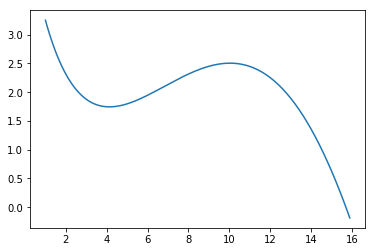

In [141]:
pyplot.plot(x, y)

It can describe, for example, the dependency of the ratings that experts give to a particular type of wine, depending on the age of that wine. In fact, the task of machine learning is to bring the complex dependence closer by using a function from a certain family. In this task, we will approximate the specified function with the help of polynomials.

As we know, the polynomial of degree n (that is, `w_0 + w_1 x + w_2 x^2 + ... + w_n x^n`) is unambiguously defined by any `n + 1` different points through which it passes. It means that its coefficients `w_0, ... w_n` can be determined from the following system of linear equations:

\begin{cases}
w_0 + w_1 x_1 + w_2 x_1^2 + \dots + w_n x_1^n = f(x_1)\\
\dots\\
w_0 + w_1 x_{n+1} + w_2 x_{n+1}^2 + \dots + w_n x_{n+1}^n = f(x_{n+1})
\end{cases}

where `x_1, ..., x_n, x_{n+1}` mark the points through which the polynomial passes and `f(x_1), ..., f(x_n), f(x_{n+1})` mark the values it must take at these points.

Let us use the described property and find the approximation of the function with the polynomial, solving a system of linear equations:

1.  Create a system of linear equations (i.e. set the matrix of coefficients A and the free vector b) for the polynomial of the first degree, which must coincide with the function f in points 1 and 15. Solve this system using the function `scipy.linalg.solve`. Draw function f and the resulting polynomial. Is it a good approximation of the original function?
2. Repeat the same steps for the polynomial of the second degree, which coincides with the function f in points 1, 8 and 15. Has the quality of approximation improved?
3. Repeat the same steps for the polynomial of the third degree, which coincides with the function f in points 1, 4, 10 and 15. Does it approximate the function well? The coefficients of this polynomial (four numbers in the following order: `w_0, w_1, w_2, w_3`) are the answers to this task. It is not necessary to round the coefficients, but you can round them up to the second digit if you want (i.e. to the number of the kind 0.42).
4. Write down the resulting numbers in a file, separated by spaces. Note that the file should consist of one line, at the end of which there should be no newline. An example solution file can be found at the end of the task (submission-2.txt).

In [133]:
def generateMatrix(points):
    n = len(points)
    matrix = []
    for x in points:
        row = []
        for i in range(n):
            row.append(x**i)
        matrix.append(row)
    return np.array(matrix)

def generateApproxVal(w, points):
    y = []
    for x in points:
        yCurr = 0
        for i in range(len(w)):
            yCurr += w[i]*(x**i)
        y.append(yCurr)
    return y

In [134]:
x_2 = [1, 15]
A_2 = generateMatrix(x_2)
y_2 = np.array(map(f, x_2))
w_2 = scipy.linalg.solve(A_2, y_2)
y_approx_2 = generateApproxVal(w_2, x)

In [135]:
x_3 = [1, 8, 15]
A_3 = generateMatrix(x_3)
y_3 = np.array(map(f, x_3))
w_3 = scipy.linalg.solve(A_3, y_3)
y_approx_3 = generateApproxVal(w_3, x)

In [136]:
x_4 = [1, 4, 10, 15]
A_4 = generateMatrix(x_4)
y_4 = np.array(map(f, x_4))
w_4 = scipy.linalg.solve(A_4, y_4)
y_approx_4 = generateApproxVal(w_4, x)

In [137]:
print w_4

[ 4.36264154 -1.29552587  0.19333685 -0.00823565]


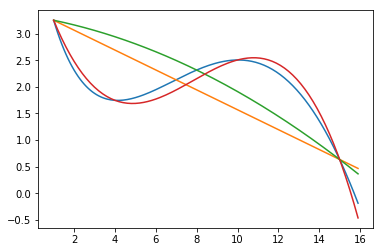

In [138]:
pyplot.plot(x, y)
pyplot.plot(x, y_approx_2)
pyplot.plot(x, y_approx_3)
pyplot.plot(x, y_approx_4)

In [139]:
with open('submission-2.txt', 'w') as outputFile:
    outputFile.writelines(string + ' ' for string in map(str, map(lambda number: round(number, 2), w_4)))